<a id='top'></a><a name='top'></a>
# Chapter 6: Reasoning with word vectors (Word2vec)

## 6.1 Semantic queries and analogies
## 6.2 Word vectors (6.2.1 - 6.2.4)

* [Introduction](#introduction)
* [6.0 Imports and Setup](#6.0)
* [6.1 Semantic queries and analogies](#6.1)
    - [6.1.1 Analogy questions](#6.1.1)
* [6.2 Word vectors](#6.2)
    - [6.2.1 Vector-oriented reasoning](#6.2.1)
    - [6.2.2 How to compute Word2vec representations](#6.2.2)
    - [6.2.3 How to use the gensim.word2vec module](#6.2.3)
    - [6.2.4 How to generate your own word vector representations](#6.2.4)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>


### Datasets

* GoogleNews-vectors-negative300.bin.gz: [script](#GoogleNews-vectors-negative300.bin.gz), [source](https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz)
* cities.csv.gz: [script](#cities.csv.gz), [source](https://www.dropbox.com/s/tcri5eyzpabhnyy/cities.csv.gz?dl=1)


### Explore

* How word vectors are created
* Using pretrained models for applications
* Reasoning with word vectors to solve real problems
* Visualizing word vectors
* Uses for word embeddings
* How every word has some geography, sentiment (positivity), and gender associated with it

### Key points

* Word vectors and vector-oriented reasoning can solve problems like analogy questions and non-synonomy relationships between words.
* It is possible to train Word2vec and other word vector embeddings on words in an application so a NLP pipeline isn't "polluted" by the GoogleNews meaning of words inherent in most Word2vec pretrained models. 
* Gensim can be used to explore, visualize, and build word vector vocabularies.
* A PCA projection of geographic word vectors like US city names can reveal the cultural closeness of places that are geographically far apart.
* If you respect sentence boundaries with n-grams and are efficient at setting up word pairs for training, you can greatly improve the accuracy of your latent semantic analysis word embeddings. 

---
<a name='6.0'></a><a id='6.0'></a>
# 6.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
import os
if not os.path.exists('setup'):
    os.mkdir('setup')

In [2]:
req_file = "setup/requirements_06.txt"

In [3]:
%%writefile {req_file}
annoy
isort
scikit-learn-intelex
watermark

Overwriting setup/requirements_06.txt


In [4]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
if IS_COLAB:
    from sklearnex import patch_sklearn
    patch_sklearn()

In [6]:
%%writefile setup/chp06_imports.py
import locale
import multiprocessing
import pprint
import random
import shlex
import subprocess
import warnings
from collections import OrderedDict
from pathlib import Path
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models.word2vec import Word2Vec
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
from watermark import watermark

Overwriting setup/chp06_imports.py


In [7]:
!isort setup/chp06_imports.py --sl
!cat setup/chp06_imports.py

Fixing /Users/gb/Desktop/examples/setup/chp06_imports.py
import locale
import multiprocessing
import pprint
import random
import shlex
import subprocess
import warnings
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
from watermark import watermark


In [8]:
import locale
import multiprocessing
import pprint
import random
import shlex
import subprocess
import warnings
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
from watermark import watermark

In [9]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)
random.seed(23)

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

numpy     : 1.23.5
matplotlib: 3.6.2
sys       : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]
pandas    : 1.5.3
seaborn   : 0.12.1



---
<a name='6.1'></a><a id='6.1'></a>
# 6.1 Semantic queries and analogies
<a href="#top">[back to top]</a>

Problem: What is the advantage of semantic queries?

Idea: They enable queries and analytics of associative and contextual nature. 

Importance: This enables the retrieval of both explicitly and implicitly derived information based on syntactic, semantic and structural information contained in the data. 

<a name='6.1.1'></a><a id='6.1.1'></a>
## 6.1.1 Analogy questions
<a href="#top">[back to top]</a>

Problem: What are analogy questions?

Idea: A particular relationship is given, and another similar relationship is identified from the alternatives. This requires a larger body of encoded knowledge and logical reasoning.

---
<a name='6.2'></a><a id='6.2'></a>
# 6.2 Word vectors
<a href="#top">[back to top]</a>

Problem: What are word vectors?

Idea: Numerical vector representations of word semantics, including literal, implied and hidden meanings. They can be created via `Word2vec` in an unsupervised manner.

Importance: Word vectors can help recover the fuzziness and subtlety of word meaning. They incorporate the nearby context of a word, the words around each word, the effect neighbors of a word have on its meaning and how those relationships affect the overall meaning of a statement. They can identify synonyms, antonyms, and words belonging to the same category. They capture all the literal meanings of a word, as well as implied and hidden meanings.

<a id='GoogleNews-vectors-negative300.bin.gz'></a><a name='GoogleNews-vectors-negative300.bin.gz'></a>
### Dataset: GoogleNews-vectors-negative300.bin.gz
<a href="#top">[back to top]</a>

In [10]:
data_file = "GoogleNews-vectors-negative300.bin.gz"
data_url = f"https://www.dropbox.com/s/965dir4dje0hfi4/{data_file}"
data_dir = Path("data/data_word2vec")
data_path = data_dir / data_file

print(f"""
data_file:\t{data_file}
data_url:\t{data_url}
data_dir:\t{data_dir}
data_path:\t{data_path}
""")


data_file:	GoogleNews-vectors-negative300.bin.gz
data_url:	https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz
data_dir:	data/data_word2vec
data_path:	data/data_word2vec/GoogleNews-vectors-negative300.bin.gz



In [11]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [12]:
print(data_url)
print(data_path)

https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz
data/data_word2vec/GoogleNews-vectors-negative300.bin.gz


In [13]:
!wget -nc -O {data_path} {data_url}

File ‘data/data_word2vec/GoogleNews-vectors-negative300.bin.gz’ already there; not retrieving.


In [14]:
!du -H {data_path}

3216888	data/data_word2vec/GoogleNews-vectors-negative300.bin.gz


---
The GoogleNews-vectors-negative300-SLIM.bin.gz is a ~270MB file stored on git with git-lfs. If you are cloning the repo you first need to install git-lfs.

Note, we don't need to extract this file, we can use as-is via:
```
load_word2vec_format(filename, binary=True)
```

In [15]:
%%time

# This takes about a minute to load locally.
# Word2vec model pretrained on Google News documents.
print(f"Load KeyedVectors from word2vec-format file, {data_path}")

vectors = KeyedVectors.load_word2vec_format(
    data_path, 
    binary=True
)

print("Done loading word2vec-format file")
HR()

print(f"Number of words in vocablulary: {len(vectors.key_to_index):,}") #Number of words in the vocabulary. 

Load KeyedVectors from word2vec-format file, data/data_word2vec/GoogleNews-vectors-negative300.bin.gz
Done loading word2vec-format file
----------------------------------------
Number of words in vocablulary: 3,000,000
CPU times: user 1min 8s, sys: 4.96 s, total: 1min 12s
Wall time: 1min 18s


In [16]:
print(type(vectors))
print(f"{len(vectors):,}")

<class 'gensim.models.keyedvectors.KeyedVectors'>
3,000,000


In [17]:
print('Marie' in vectors)

True


In [18]:
# %%time
# print(vectors.most_similar("Marie", topn=10))
# HR()

---
API Note: `nessvector()`

Compose a word vector for each "ness" like placeness, humanness, femaleness, etc.

We add the word vector for each synonym, then divide to find the average. This can be seen as a "normalized" score for each "ness", such as placeness, etc.

* https://github.com/totalgood/nlpia/blob/master/src/nlpia/book/examples/ch06_nessvectors.py

In [19]:
word_vectors = vectors

# Note that we have to manually define these concepts via synonyms
COMPONENT_WORDS = OrderedDict([
    ('placeness', 'geography Geography geographic geographical geographical_location location locale locations proximity'.split()),
    ('peopleness', 'human Humans homo_sapiens peole people individuals humankind people men women'.split()),
    ('animalness', 'animal mammal carnivore animals Animal animal_welfare dog pet cats ani_mal'.split()),
    ('conceptness', 'concept concepts idea'.split()),
    ('femaleness', 'female Female females femal woman girl lady'.split()),
])

def component_vector(words, debug=False):
    vector = np.zeros(300)
    if debug:
        print(f"Number of words: {len(words)}")
    for i, word in enumerate(words):
        v = word_vectors[word]
        if debug:
            print(i, vector[:3].round(5))
        vector += v / len(words)
    if debug:
        HR()
    return vector
    
COMPONENTS = pd.DataFrame(
    [component_vector(words, debug=True) for (component, words) in COMPONENT_WORDS.items()],
    index=[component for (component, words) in COMPONENT_WORDS.items()]
)

def nessvector(target, components=COMPONENTS):
    target = word_vectors[target] if isinstance(target, str) else target
    vector = word_vectors.cosine_similarities(target, components.values)
    return pd.Series((vector - vector.mean()) / .15, index=components.index)

Number of words: 9
0 [0. 0. 0.]
1 [ 0.01519 -0.00022  0.00377]
2 [ 0.00608 -0.03017  0.02525]
3 [ 0.0043  -0.03749  0.01408]
4 [ 0.00681 -0.02876  0.01577]
5 [ 0.00869 -0.02962  0.00368]
6 [ 0.01233 -0.04031  0.00859]
7 [ 1.028e-02 -3.162e-02 -9.000e-05]
8 [ 0.00442 -0.02213  0.00511]
----------------------------------------
Number of words: 10
0 [0. 0. 0.]
1 [0.00559 0.00923 0.01079]
2 [0.05461 0.01128 0.00405]
3 [ 0.0616   0.02021 -0.00684]
4 [0.0782  0.01781 0.00454]
5 [0.10457 0.01589 0.00743]
6 [ 0.11223  0.01758 -0.00223]
7 [0.12429 0.01942 0.01163]
8 [0.15066 0.0175  0.01453]
9 [0.14587 0.0342  0.02234]
----------------------------------------
Number of words: 10
0 [0. 0. 0.]
1 [ 0.00081  0.02051 -0.01699]
2 [ 0.01087  0.06719 -0.03633]
3 [ 0.00789  0.08066 -0.04912]
4 [ 0.00988  0.10537 -0.07275]
5 [ 0.0006   0.12236 -0.07521]
6 [-0.0285   0.1311  -0.07628]
7 [-0.02337  0.12887 -0.09357]
8 [-0.01973  0.14557 -0.11115]
9 [-0.02676  0.17135 -0.14025]
-----------------------------

In [20]:
nessvector('Marie_Curie').round(2)

placeness     -0.46
peopleness     0.35
animalness     0.17
conceptness   -0.32
femaleness     0.26
dtype: float64

In [21]:
nessvector('Seattle').round(2)

placeness      0.26
peopleness    -0.06
animalness    -0.01
conceptness    0.18
femaleness    -0.36
dtype: float64

In [22]:
nessvector('Portland').round(2)

placeness      0.37
peopleness    -0.20
animalness     0.07
conceptness    0.02
femaleness    -0.25
dtype: float64

In [23]:
nessvector('Timbers').round(2)

placeness     -0.04
peopleness     0.28
animalness    -0.33
conceptness    0.19
femaleness    -0.10
dtype: float64

---
API Note: `vectors.most_similar()`

Find the top-N most similar keys.
Positive keys contribute positively towards the similarity, negative keys negatively.

This method computes cosine similarity between a simple mean of the projection
weight vectors of the given keys and the vectors for each key in the model.
The method corresponds to the `word-analogy` and `distance` scripts in the original
word2vec implementation.

In [24]:
# king - man + woman = queen 
vectors.most_similar(
    'King woman'.split(),
    negative='man'.split()
)

[('Queen', 0.5515626668930054),
 ('Oprah_BFF_Gayle', 0.47597548365592957),
 ('Geoffrey_Rush_Exit', 0.46460166573524475),
 ('Princess', 0.4533674716949463),
 ('Yvonne_Stickney', 0.4507041573524475),
 ('L._Bonauto', 0.4422135353088379),
 ('gal_pal_Gayle', 0.4408389925956726),
 ('Alveda_C.', 0.4402790665626526),
 ('Tupou_V.', 0.4373864233493805),
 ('K._Letourneau', 0.4351031482219696)]

In [25]:
# French - man + woman
vectors.most_similar(
    'French France woman famous scientist chemistry Nobel_Prize radiation physics name person human'.split(),
    negative='man man man man school ecole place country'.split()
)

[('Pierre_Curie', 0.48349955677986145),
 ('Henri_Becquerel', 0.47997117042541504),
 ('Otto_Warburg', 0.4735907316207886),
 ('blackbody_radiation', 0.4725410044193268),
 ('Nobelist', 0.46358683705329895),
 ('Kary_Mullis', 0.4630543291568756),
 ('Seoul_Soongsil_University', 0.46133187413215637),
 ('George_Gamow', 0.45909202098846436),
 ('Nobel_Chemistry', 0.45735475420951843),
 ('Alivisatos', 0.45495474338531494)]

In [26]:
# Pierre Curie - man + Nobel
vectors.most_similar(
    'Pierre_Curie Nobel_Prize famous smart French physics woman women person name'.split(),
    negative='man male male geography city Pierre prize'.split()
)

[('Madame_Curie', 0.441272497177124),
 ('Ada_Lovelace', 0.4309345781803131),
 ('economist_Franco_Modigliani', 0.42140284180641174),
 ('physicist_Niels_Bohr', 0.4198070168495178),
 ('Murray_Gell_Mann', 0.41829755902290344),
 ('George_Gamow', 0.417612761259079),
 ('brilliant_mathematician', 0.41744929552078247),
 ('Bertha_von_Suttner', 0.4144267439842224),
 ('Norbert_Wiener', 0.41063863039016724),
 ('Charles_Babbage', 0.40797877311706543)]

In [27]:
vectors.most_similar(positive=['Timbers', 'Seattle'], negative=['Portland'])

[('Sounders', 0.627106249332428),
 ('Sounders_FC', 0.6018840670585632),
 ('Seattle_Sounders', 0.5471113920211792),
 ('Chivas_USA', 0.5424385666847229),
 ('Seattle_Sounders_FC', 0.5356541872024536),
 ('Portland_Timbers', 0.5205711722373962),
 ('Chivas', 0.5127005577087402),
 ('Colorado_Rapids', 0.49907442927360535),
 ('Rapids', 0.4931820034980774),
 ('FC_Dallas', 0.4918207824230194)]

In [28]:
vectors.doesnt_match(['Japan', 'snow', 'ice', 'rain'])

'Japan'

In [29]:
vectors['place'].std()

0.12100203

In [30]:
placeness = np.zeros(300)

for word in COMPONENT_WORDS['placeness']:
        v = vectors[word]
        #print(v.min(), v.max())
        placeness += v
        
placeness /= 9.
pd.DataFrame(vectors.similar_by_vector(placeness))

,0,1
0,geographical_location,0.817759
1,geographic,0.785667
2,geographical,0.772901
3,geography,0.738597
4,location,0.725341
5,proximity,0.711645
6,locale,0.662889
7,geographical_proximity,0.649245
8,geographically,0.640669
9,geographic_proximity,0.638603


In [31]:
vectors.cosine_similarities(
    placeness,
    [word_vectors[word] for word in 'place geography location address position'.split()]
)

array([0.21323944, 0.73859698, 0.72534065, 0.16857953, 0.21048562])

In [32]:
animalness = np.zeros(300)

for word in 'animal mammal carnivore animals Animal animal_welfare dog pet cats ani_mal'.split():
    v = vectors[word]
    #print(v.min(), v.max())
    animalness += v / 10.
    
pd.DataFrame(vectors.similar_by_vector(animalness))

,0,1
0,animal,0.894464
1,animals,0.849436
2,cats,0.791349
3,pet,0.755938
4,dog,0.755310
5,Animal,0.741425
6,dogs,0.739847
7,felines,0.730020
8,cat,0.722568
9,animal_welfare,0.712067


In [33]:
vectors.most_similar('female')

[('male', 0.8405334949493408),
 ('Female', 0.7159764766693115),
 ('females', 0.6656177639961243),
 ('femal', 0.5905246138572693),
 ('males', 0.5729263424873352),
 ('accomplice_Hudgens', 0.5577225685119629),
 ('women', 0.5556280612945557),
 ('Male', 0.5534578561782837),
 ('Gestapo_massacred', 0.5214705467224121),
 ('biochemist_Peggy_Whitson', 0.5153282880783081)]

In [34]:
femaleness = np.zeros(300)
femaleness_input = 'female Female females femal woman girl lady'.split()
femalennes_n = float(len(femaleness_input))

print(femaleness_input)
print(femalennes_n)

HR()

for word in femaleness_input:
    v = vectors[word]
    femaleness += v / femalennes_n

word_vectors.similar_by_vector(femaleness)

['female', 'Female', 'females', 'femal', 'woman', 'girl', 'lady']
7.0
----------------------------------------


[('female', 0.8353393077850342),
 ('woman', 0.7825490832328796),
 ('male', 0.7465065717697144),
 ('females', 0.7222081422805786),
 ('girl', 0.6968225240707397),
 ('lady', 0.6790707111358643),
 ('Female', 0.6751645803451538),
 ('women', 0.6464763283729553),
 ('males', 0.6279425024986267),
 ('accomplice_Hudgens', 0.6241015195846558)]

<a name='6.2.1'></a><a id='6.2.1'></a>
## 6.2.1 Vector-oriented reasoning
<a href="#top">[back to top]</a>

Problem: What is the vector-oriented reasoning achieved with word vectors?

Idea: Word2vec enables transforming natural language vectors of token occurrence counts and frequencies into the vector space of lower-dimensional Word2vec vectors. 

Importance: In the lower-dimensional space, we can do various mathematical operations, and then convert back to a natural language spae. This capability is very useful for chatbots, search engines, question answering systems, information extraction algorithms, etc.

In [35]:
'San Francisco' in vectors

False

In [36]:
'San_Francisco' in vectors

True

In [37]:
vectors.most_similar(positive=['San_Francisco', 'Colorado'], negative=['California'])

[('Denver', 0.7491148114204407),
 ('Boulder', 0.6387513875961304),
 ('Fort_Collins', 0.5858851075172424),
 ('St._Louis', 0.5778958797454834),
 ('Colorado_Springs', 0.5763417482376099),
 ('Seattle', 0.5675066113471985),
 ('Pittsburgh', 0.5509663224220276),
 ('Philadelphia', 0.5451167821884155),
 ('Cincinnati', 0.5333347320556641),
 ('Boston', 0.5307804942131042)]

<a id='cities.csv.gz'></a><a name='cities.csv.gz'></a>
### Dataset: cities.csv.gz
<a href="#top">[back to top]</a>

In [38]:
data_cities_file = "cities.csv.gz"
data_cities_url = f"https://www.dropbox.com/s/tcri5eyzpabhnyy/{data_cities_file}?dl=1"
data_cities_dir = Path("data/data_cities")
data_cities_path = data_cities_dir / data_cities_file

print(f"""
data_cities_file:\t{data_cities_file}
data_cities_url:\t{data_cities_url}
data_cities_dir:\t{data_cities_dir}
data_cities_path:\t{data_cities_path}
""")


data_cities_file:	cities.csv.gz
data_cities_url:	https://www.dropbox.com/s/tcri5eyzpabhnyy/cities.csv.gz?dl=1
data_cities_dir:	data/data_cities
data_cities_path:	data/data_cities/cities.csv.gz



In [39]:
if not os.path.exists(data_cities_dir):
    os.makedirs(data_cities_dir)

In [40]:
if not data_cities_path.is_file():
    print(f"Downloading {data_cities_url} to {data_cities_path}")
    subprocess.run(shlex.split(f"wget -q -O {data_cities_path} {data_cities_url}"))
    print("Done.")
else:
    print(f"{data_cities_path} exists.")

data/data_cities/cities.csv.gz exists.


<a name='6.2.2'></a><a id='6.2.2'></a>
## 6.2.2 How to compute Word2vec representations
<a href="#top">[back to top]</a>

Problem: How do we calculate vector representations of words?

Idea: There are two ways. The *skip-gram* predicts the context of words (output words) from a word of interest (the input word). The *continuous bag-of-word* (CBOW) approach predicts the target word (output word) from the nearby words (input words). 

Importance: Although we train a predictive model, it is not the inference that is important, but the internal representation in the form of vectors that is important. This representation captures more of the meaning of the target word than was possible with word-topic vectors from latent semantic analysis and latent Dirichilet allocation. 

<a name='6.2.3'></a><a id='6.2.3'></a>
## 6.2.3 How to use the gensim.word2vec module
<a href="#top">[back to top]</a>

Problem: How can we use a pretrained word vector model?

Idea: *Gensim* is a popular open-source Python library for representing documents as semantic vectors. We can use   `gensim.models.keyedvectors` to easily store and query word vectors.

In [41]:
# Already loaded 
print(f"Load KeyedVectors from word2vec-format file, {data_path}")
print(type(vectors))

Load KeyedVectors from word2vec-format file, data/data_word2vec/GoogleNews-vectors-negative300.bin.gz
<class 'gensim.models.keyedvectors.KeyedVectors'>


In [42]:
# Word2vec synonomy (similarity) 
vectors.most_similar(positive=['cooking', 'potatoes'], topn=5)

[('cook', 0.6973530650138855),
 ('oven_roasting', 0.6754531264305115),
 ('Slow_cooker', 0.6742031574249268),
 ('sweet_potatoes', 0.6600280404090881),
 ('stir_fry_vegetables', 0.6548759341239929)]

In [43]:
vectors.most_similar(positive=['germany', 'france'], topn=1)

[('europe', 0.7222040295600891)]

In [44]:
# Determine unrelated terms
# Returns the term with the highest distance to all other list terms.
vectors.doesnt_match("potatoes milk cake computer".split())

'computer'

In [45]:
# Famous 'king + woman - man = queen' example
vectors.most_similar(positive=['king', 'woman'], negative=['man'], topn=2)

[('queen', 0.7118193507194519), ('monarch', 0.6189674139022827)]

In [46]:
# Calculate similarity between two terms
vectors.similarity('princess', 'queen')

0.7070532

In [47]:
# Calculate similarity between two terms
vectors.similarity('US', 'USA')

0.25336528

In [48]:
# Access raw word vectors
vectors['phone'][:20]

array([-0.01446533, -0.12792969, -0.11572266, -0.22167969, -0.07373047,
       -0.05981445, -0.10009766, -0.06884766,  0.14941406,  0.10107422,
       -0.03076172, -0.03271484, -0.03125   , -0.10791016,  0.12158203,
        0.16015625,  0.19335938,  0.0065918 , -0.15429688,  0.03710938],
      dtype=float32)

In [49]:
FIG_SIZE = (10, 8)
FONT_SIZE = 12
ALPHA = 0.75
SCATTER_SIZE = 10

words_n = 500
print(f"Original length: {len(vectors.index_to_key):,}")
print(f"Subset length: {words_n}")

# In order to be able to use learning_rate='auto' in TSNE constructor, 
# vectors_subset needs to have a shape, hence we convert this list to a Numpy array.
vectors_subset = np.array([vectors[w] for w in vectors.index_to_key[:words_n]])

print(f"Dataset shape: {vectors_subset.shape}") 

# Map word embeddings to two-dimensional vectors.
# This is an embedding of the training data in low-dimensional space.

# First, convert affinities of data points to probabilities.
x_embedded_prob = TSNE(
    n_components=2, # Use for a 2D graph
    random_state=42,
    learning_rate='auto',
    init='pca',
    verbose=1
)

x_embedded_prob.__dict__


Original length: 3,000,000
Subset length: 500
Dataset shape: (500, 300)


{'n_components': 2,
 'perplexity': 30.0,
 'early_exaggeration': 12.0,
 'learning_rate': 'auto',
 'n_iter': 1000,
 'n_iter_without_progress': 300,
 'min_grad_norm': 1e-07,
 'metric': 'euclidean',
 'metric_params': None,
 'init': 'pca',
 'verbose': 1,
 'random_state': 42,
 'method': 'barnes_hut',
 'angle': 0.5,
 'n_jobs': None,
 'square_distances': 'deprecated'}

In [54]:
# Return ndarray of shape (n_samples, n_components)
#x_embedded = x_embedded_prob.fit_transform(vectors_subset)
x_embedded = x_embedded_prob.fit_transform(vectors_subset)
print("Done")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.800760
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.052994
[t-SNE] KL divergence after 1000 iterations: 1.354367
Done


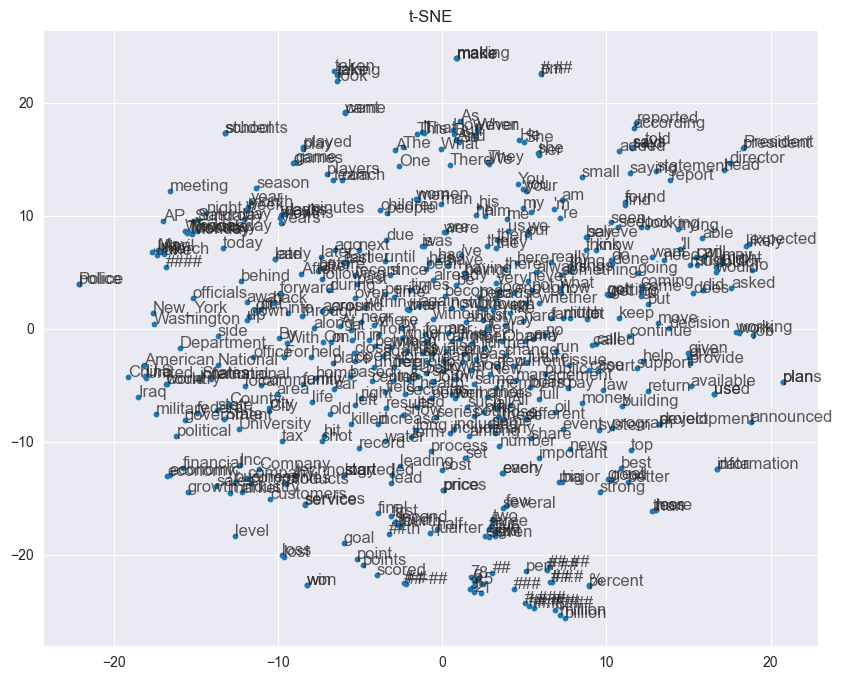

In [55]:
plt.figure(figsize=FIG_SIZE)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], s=SCATTER_SIZE)
plt.title("t-SNE")

for label, x, y in zip(
    vectors.index_to_key[:words_n],
    x_embedded[:, 0],
    x_embedded[:, 1]):
    plt.annotate(label, (x,y), fontsize=FONT_SIZE, alpha=ALPHA)

plt.show()

<a name='6.2.4'></a><a id='6.2.4'></a>
## 6.2.4 How to generate your own word vector representations
<a href="#top">[back to top]</a>

Problem: What is the use-case for generating your own word vector representations?

Idea: Sometimes you documents uses words in a way that is atypical of Google News. Or, your words may be particularly rare, or your text uses vocabulary in unique ways within a specialized domain, such as medical texts or transcripts. In this case, a domain-specific word model may improve model accuracy. You will still need a lot of documents for such training. We can use the same `gensim` library, however we will need to preprocess the corpus.

More resources:

* https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial
* https://radimrehurek.com/gensim/models/word2vec.html

**Preprocessing steps**

Problem: How to prevent word vectors from learning irrelevant word occurrences in neighboring sentences?

Idea: We need to break documents into sentences, and sentences into tokens. The gensim word2vec model expects a list of sentences, where each sentence is broken up into tokens. 

In [56]:
# Creating a Word2vec model
token_list = [
    ['radiology', 'to', 'provide', 'early', 'intervention/early', 'childhood', 'special', 'education', 'services', 'to', 'eligible', 'children', 'and', 'their', 'families'],
    ['essential', 'job', 'functions'],
    ['participate', 'as', 'a', 'transdisciplinary', 'team', 'member', 'to', 'complete', 'educational', 'assessments', 'for']
]

In [57]:
model_dir = Path("models/model_generated")
model_path = model_dir / "my_domain_specific_word2vec_model"

print(f"model_dir:\t{model_dir}")
print(f"model_path:\t{model_path}")

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_dir:	models/model_generated
model_path:	models/model_generated/my_domain_specific_word2vec_model


In [58]:
# Count the number of computer cores
cores = multiprocessing.cpu_count() 
print(cores)

4


**Train your domain-specific Word2vec model**

Problem: How to train a customized Word2vec module?

Idea: Create a Gensim Word2Vec model with customized vocabulary/dataset.

API notes:
 
 ```
Word2Vec(
    sentences=None,
    corpus_file=None,
    vector_size=100,
    alpha=0.025,
    window=5,
    min_count=5,
    max_vocab_size=None,
    sample=0.001,
    seed=1,
    workers=3,
    min_alpha=0.0001,
    sg=0,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    hashfxn=<built-in function hash>,
    epochs=5,
    null_word=0,
    trim_rule=None,
    sorted_vocab=1,
    batch_words=10000,
    compute_loss=False,
    callbacks=(),
    comment=None,
    max_final_vocab=None,
    shrink_windows=True,
)
```

In [59]:
num_features = 300
min_word_count = 1 # Default is 3, but set to 1 for demonstration purposes.
num_workers = 2
window_size = 6
subsampling = 1e-3

model = Word2Vec(
    token_list,
    workers=num_workers,
    vector_size=num_features,
    min_count=min_word_count,
    window=window_size,
    sample=subsampling
)

model

In [60]:
model_path

PosixPath('models/model_generated/my_domain_specific_word2vec_model')

In [61]:
model.save(str(model_path))

In [62]:
!ls -l {model_path}

-rw-r--r--  1 gb  staff  70889 Mar 30 21:12 models/model_generated/my_domain_specific_word2vec_model


---
Test the newly trained and saved Word2vec model by loading it.

In [63]:
# Loading a saved Word2vec model
model = Word2Vec.load(str(model_path))

print(type(model))
print(model)
HR()

print(type(model.wv))
print(model.wv)
print(f"{len(model.wv):,}")

<class 'gensim.models.word2vec.Word2Vec'>
Word2Vec<vocab=27, vector_size=300, alpha=0.025>
----------------------------------------
<class 'gensim.models.keyedvectors.KeyedVectors'>
KeyedVectors<vector_size=300, 27 keys>
27


In [64]:
if ('radiology' in model.wv):
    res_1 = model.wv.most_similar('radiology')
    pp.pprint(res_1)

[   ('team', 0.1458040475845337),
    ('and', 0.05037136375904083),
    ('participate', 0.043424081057310104),
    ('job', 0.04227512702345848),
    ('education', 0.03231405094265938),
    ('early', 0.019078999757766724),
    ('children', 0.016671979799866676),
    ('as', 0.016543611884117126),
    ('services', 0.01644025929272175),
    ('functions', 0.01242887880653143)]
